In [54]:
# =========================================================
# Imports
# =========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import interp1d
from plotting_functions import *

In [82]:
# =========================================================
# Funtions
# =========================================================

class precip_time_series:
    def __init__(self, data_path):

        self.data,self.statid = self.read_raw_data_as_pandas_df(data_path)
        
        self.padded = False

        self.events = None
        
        self.dimensioneless_curves = None
    
        self.interpolated_events=None
        
    def read_raw_data_as_pandas_df(self, raw_data_file_path):

        # Read file with timestamp as index
        precip = pd.read_csv(raw_data_file_path, encoding="ISO-8859-1",index_col=1)

        # Timestamps str -> datetime
        precip.index = pd.to_datetime(precip.index)

        # Save ID of station
        station_id = str(precip.station.iloc[0])

        # Remove column with station ID
        precip = precip.drop("station",axis=1) 

        return precip,station_id
    

    def pad_and_resample(self,freq = '5min',pad_value = 0):
        # Resample the data to the specified frequency and pad missing values with pad_value
        self.data = self.data.resample(freq).sum().fillna(pad_value)
        self.padded = True

    def get_events(self,threshold='11h',min_duration = 30, min_precip = 1):
        
        if not self.padded:
            self.pad_and_resample()

        self.init_events(threshold)
        self.filter_events_by_length(min_duration)
        self.filter_events_by_amount(min_precip)

    def init_events(self,threshold):
        
        precip = self.data
        
        # Size of timesteps
        time_delta = precip.index[1]-precip.index[0]

        # Rolling 11 hour sum
        precip_sum = precip.rolling(threshold).sum()

        # dates with no precip last 11 hours
        dates_w_zero_sum = precip_sum.index[(precip_sum.mask(precip_sum!=0)==precip_sum).values[:,0]]

        # Add first date with rain
        for date in precip.index:
            if precip.loc[date].values[0] != 0:
                start_dates = [date]
                break

        # Save start and end dates
        end_dates   = []
        for date in tqdm(dates_w_zero_sum):
            if precip_sum.loc[date- time_delta].values[0]!=0:
                end_dates += [date- pd.to_timedelta(threshold)]
            if precip_sum.loc[date+ time_delta].values[0]!=0:
                start_dates += [date+ time_delta]
        
        # Add end to last event
        for date in reversed(precip.index):  # Iterate from last to first
            if precip.loc[date].values[0] != 0:  # Check if value is not zero
                end_dates += [date]
                break  # Stop at the first nonzero value
        
        # Save events as list of tuples
        events = []
        for i in range(len(end_dates)):
            events+=[(start_dates[i],end_dates[i])]

        # update events
        self.events = events

    def filter_events_by_length(self,min_duration):
        
        # Remove events with duration under min duration
        filtered_events = [event for event in self.events if event[1]-event[0]>=pd.Timedelta(minutes=min_duration)]

        # Update events
        self.events = filtered_events
    
    def filter_events_by_amount(self,min_precip):
        
        # Remove events with total precip under minimum
        filtered_events = [event for event in self.events if self.data.loc[event[0]:event[1]].sum().values[0]>=min_precip]
        
        # update events
        self.events = filtered_events

    def create_dimensioneless_curves(self):

        # Make sure events have been computed
        if self.events == None:
            self.get_events()
        
        # Make list of nparrays containing the values of the dimensioneless curve
        dimensioneless_curves = [self.get_dimensioneless_curve(self.data.loc[event[0]:event[1]].values) for event in self.events]

        # Assign to global value
        self.dimensioneless_curves = dimensioneless_curves
        
    def get_dimensioneless_curve(self,series):
    
        # Calculate cumulative rainfall
        cumulative_rainfall = np.cumsum(series)
        cumulative_rainfall = np.append([0],cumulative_rainfall)

        # normalize
        normalized_cumulative_rainfall = cumulative_rainfall/cumulative_rainfall[-1]

        return normalized_cumulative_rainfall
    
    def create_interpolated_events(self, n):
        # Make sure events have been computed
        if self.dimensioneless_curves == None:
            self.dimensioneless_curves()
        
        # Make list of nparrays containing the values of the dimensionless curve
        interpolated_events = [self.get_interpolated_event(event, n) for event in self.dimensioneless_curves]

        # Assign to global value
        self.interpolated_events = interpolated_events

        
    def get_interpolated_event(self, series, n):
        # Calculate cumulative rainfall
        normalized_cumulative_rainfall = series

        # Define target points for bin_number bins
        target_points = np.linspace(0, 1, n+1)

        # Create interpolation function based on existing data points
        rainfall_times = np.array(range(0, len(normalized_cumulative_rainfall)))

        # Normalize time from 0 to 1
        normalized_time = (rainfall_times - rainfall_times[0]) / (rainfall_times[-1] - rainfall_times[0])
        interpolation_func = interp1d(normalized_time, normalized_cumulative_rainfall, kind='linear', fill_value="extrapolate")

        # Interpolate values at target points
        interpolated_values = interpolation_func(target_points)
    
        return interpolated_values            
        
    def plot_all_events(self):
        plt.figure()
        plt.plot(self.data.index,self.data.values)
        for i,dates in enumerate(self.events):
            plt.vlines(dates[0],colors="green",linestyles='--',ymin=0,ymax=3)
            plt.vlines(dates[1],colors="red",linestyles='--',ymin=0,ymax=3)
        plt.legend(["Precipitation","Event start","Event end"])
        plt.ylabel("[mm]")
        plt.title("Padded precip data, with events")

    def plot_secific_event(self,event_idx):

        # Size of timesteps
        time_delta = self.data.index[1]-self.data.index[0]
        time_delta_minuts = time_delta.seconds/60

        plt.figure()
        event = (self.data.loc[self.events[event_idx][0]:self.events[event_idx][1]])

        # plot were right edge align w timestamp
        plt.bar(event.index-time_delta,event.values[:,0],width=pd.Timedelta(minutes=time_delta_minuts),align="edge")

        plt.legend(["Precipitation"])
        plt.title(f"Event {event_idx}")

    def plot_secific_event_w_hist(self,event_idx):

        # Size of timesteps
        time_delta = self.data.index[1] - self.data.index[0]
        time_delta_minutes = time_delta.seconds / 60

        # Extract event data
        event = self.data.loc[self.events[event_idx][0]:self.events[event_idx][1]]

        # Create a figure with two subplots (1 row, 2 columns)
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # **Plot time series (left subplot)**
        axes[0].bar(event.index - time_delta, event.values[:, 0], 
                    width=pd.Timedelta(minutes=time_delta_minutes), align="edge")
        axes[0].set_title(f"Event {event_idx}")
        axes[0].set_ylabel("Precipitation (mm)")
        axes[0].set_xlabel("Time")
        axes[0].legend(["Precipitation"])

        # **Plot histogram (right subplot)**
        axes[1].hist(event.values[:, 0], bins=10, edgecolor='black', alpha=0.7)
        axes[1].set_title("Precipitation Histogram")
        axes[1].set_xlabel("Precipitation (mm)")
        axes[1].set_ylabel("Frequency")

        # Adjust layout for clarity
        plt.tight_layout()

    def plot_specific_dimensioneless_curves(self,event_idxs):
        plt.figure()

        for idx in event_idxs:
            x_values = np.linspace(0,1,len(self.dimensioneless_curves[idx]))
            plt.plot(x_values,self.dimensioneless_curves[idx],label = f"Event: {idx+1}")
        plt.legend()
        plt.title("Dimensioneless curves")
        
        
    def plot_specific_dimensionless_curve(self,event_idx, plot_boundaries=False):
        plt.figure()

        x_values = np.linspace(0,1,len(self.dimensionless_curves[event_idx]))

        # Define time intervals
        total_duration = x_values[-1]  # e.g., 270 minutes
        boundaries = np.linspace(0, total_duration, 6)  # 6 boundaries -> 5 segments

        plt.plot(x_values,self.dimensionless_curves[event_idx], label = f"Event: {event_idx+1}")
        plt.scatter(x_values,self.dimensionless_curves[event_idx], label = f"Event: {event_idx+1}")
        for marker in boundaries:
                plt.axvline(marker, color='red', linestyle='--', label='Fifth Boundary' if marker==boundaries[1] else "")
        plt.legend()
        plt.title("dimensionless curves")              


class rainfall_analysis:
    def __init__(self,ts: precip_time_series):
        self.ts = ts
        self.metrics = {} 
        
        # Prepere ts for analysis
        if not self.ts.padded:
            ts.pad_and_resample()

        if ts.events == None:
            ts.get_events()
        
        if ts.dimensioneless_curves == None:
            ts.create_dimensioneless_curves()
            

    def compute_intermittency(self,series):
            
            total_timesteps = len(series)
            wet = series>0
            transistions = (wet[:-1] != wet[1:]).sum()
            
            intermittency = transistions/total_timesteps
    
            return intermittency 

    def compute_rcg_idx(self,series):
            
            # Culmitative sum
            culmitative_sum = np.cumsum(series)
            
            # Normalize
            culmitative_sum /= culmitative_sum[-1]

            #first idx over 0.5
            idx = np.argmax(culmitative_sum>0.5)

            return idx

    def compute_rcg(self):

        time_delta = self.ts.data.index[1]-self.ts.data.index[0]
        time_delta_minuts = time_delta.seconds/60

        # first index over center of mass
        rcg_indeces = np.array([self.compute_rcg_idx(self.ts.data.loc[event[0]:event[1]].values) for event in self.ts.events])

        # time of center
        toc = np.array([self.ts.data.loc[event[0]:event[1]].index[rcg_indeces[i]] for i,event in enumerate(self.ts.events)])

        # duration until center
        tcg = np.array([time_delta_minuts + (toc[i] - event[0]).total_seconds()/60 for i,event in enumerate(self.ts.events)]).reshape(self.metrics["duration"].shape)

        # rcg
        rcg = tcg/self.metrics["duration"]

        return rcg

    def compute_mass_dist_indicators(self,series):

        """
        Thoughts:
        Current implementation treats time as discrete, alternatively one could use averages if 
        0.33*T is not a multiple of stepsize.
        """
        # length of series
        steps = len(series)

        # peak_idx
        peak_idx = np.argmax(series)

        # Culmitative sum
        culmitative_sum = np.cumsum(series)


        # Mass distribution indicators
        if peak_idx == 0:
            m1   = culmitative_sum[peak_idx]/culmitative_sum[-1]
        else:
            m1   = culmitative_sum[peak_idx]/(culmitative_sum[-1]-culmitative_sum[peak_idx-1])
        
        m2   = (series[peak_idx]/culmitative_sum[-1])[0]
        m3   = culmitative_sum[np.int32(np.round(steps/3))-1]/culmitative_sum[-1]
        m4   = culmitative_sum[np.int32(np.round(steps*0.3))-1]/culmitative_sum[-1]
        m5   = culmitative_sum[np.int32(np.round(steps/2))-1]/culmitative_sum[-1]    

        return np.array([m1,m2,m3,m4,m5])

    def compute_time_based_skewness(self):

        time_delta = self.ts.data.index[1]-self.ts.data.index[0]
        time_delta_minuts = time_delta.seconds/60

        # first index over center of mass
        CoM_idx = np.array([self.compute_rcg_idx(self.ts.data.loc[event[0]:event[1]].values) for event in self.ts.events])

        # time of center
        toc = np.array([self.ts.data.loc[event[0]:event[1]].index[CoM_idx[i]] for i,event in enumerate(self.ts.events)])

        # duration until center
        tcg = np.array([time_delta_minuts + (toc[i] - event[0]).total_seconds()/60 for i,event in enumerate(self.ts.events)]).reshape(self.metrics["duration"].shape)
        
        time_based_skewness_list = np.zeros(tcg.shape)

        for i, event in enumerate(self.ts.events):
            series = self.ts.data.loc[event[0]:event[1]].values

            numerator = np.array([((j+1)*time_delta_minuts-tcg[i])**3 * precip for j,precip in enumerate(series)]).sum()

            total_precip = series.sum()

            sigma_t = np.sqrt(np.array([((j+1)*time_delta_minuts-tcg[i])**2 * precip for j,precip in enumerate(series)]).sum()/total_precip)

            time_based_skewness_list[i] = numerator/(total_precip*sigma_t**3)

        
        return time_based_skewness_list

    def compute_time_based_kurtosis(self):

        time_delta = self.ts.data.index[1]-self.ts.data.index[0]
        time_delta_minuts = time_delta.seconds/60

        # first index over center of mass
        CoM_idx = np.array([self.compute_rcg_idx(self.ts.data.loc[event[0]:event[1]].values) for event in self.ts.events])

        # time of center
        toc = np.array([self.ts.data.loc[event[0]:event[1]].index[CoM_idx[i]] for i,event in enumerate(self.ts.events)])

        # duration until center
        tcg = np.array([time_delta_minuts + (toc[i] - event[0]).total_seconds()/60 for i,event in enumerate(self.ts.events)]).reshape(self.metrics["duration"].shape)
        
        time_based_kurtosis_list = np.zeros(tcg.shape)

        for i, event in enumerate(self.ts.events):
            series = self.ts.data.loc[event[0]:event[1]].values

            numerator = np.array([((j+1)*time_delta_minuts-tcg[i])**4 * precip for j,precip in enumerate(series)]).sum()

            total_precip = series.sum()

            sigma_t = np.sqrt(np.array([((j+1)*time_delta_minuts-tcg[i])**2 * precip for j,precip in enumerate(series)]).sum()/total_precip)

            time_based_kurtosis_list[i] = numerator/(total_precip*sigma_t**4)

        
        return time_based_kurtosis_list

    def huff_quantile(self,ts):
      
        sums = self.split_ts_sum(ts,4)

        quantile = np.argmax(sums)+1

        return quantile
    
    
    def huff_quantile_molly (self,ts):
        
        interpolated_cumulative = self.get_interpolated_event(ts,4)
        interpolated_incremental =  np.diff(interpolated_cumulative)
        quantile = np.argmax(interpolated_incremental)+1

        return quantile        

    def quintile_class(self,ts):
      
        sums = self.split_ts_sum(ts,5)

        quintile = np.argmax(sums)+1

        return quintile

    def third_classification_max_percent(self,ts):
      
        sums = self.split_ts_sum(ts,3)

        third = np.argmax(sums)+1

        return third

    def get_interpolated_event(self, series, n):
        # Calculate cumulative rainfall
        normalized_cumulative_rainfall = series

        # Define target points for bin_number bins
        target_points = np.linspace(0, 1, n+1)

        # Create interpolation function based on existing data points
        rainfall_times = np.array(range(0, len(normalized_cumulative_rainfall)))

        # Normalize time from 0 to 1
        normalized_time = (rainfall_times - rainfall_times[0]) / (rainfall_times[-1] - rainfall_times[0])
        interpolation_func = interp1d(normalized_time, normalized_cumulative_rainfall, kind='linear', fill_value="extrapolate")

        # Interpolate values at target points
        interpolated_values = interpolation_func(target_points)
    
        return interpolated_values            
    
    def split_ts_sum(self,ts,num):
        
        # if list length divisible by num, equal split trivial
        if len(ts) % num == 0:
            splits = np.array_split(ts.values,num)
            sums = [split.sum() for split in splits]
            
            return sums
        
        # Find temporal resolution of data
        time_delta = ts.index[1]-ts.index[0]
        time_delta_minuts = time_delta.seconds/60

        # When does recording start and end
        ts_start = ts.index[0]-time_delta
        ts_end   = ts.index[-1]

        # Find the num+1 timestamps between which the num equal length splits are defined
        time_splits = pd.date_range(start=ts_start, end=ts_end, periods=num+1)

        # Init list for saving splits
        list_of_splits = []

        for i in range(num+1):
            # first and last split timestamp, is just edges of entire array and is not needed
            if i != 0 and i!= num:
                
                # Find closest previous and next x-minute marks
                prev_time = time_splits[i].floor(f"{time_delta_minuts}min")  
                next_time = time_splits[i].ceil(f"{time_delta_minuts}min")   
                mid_time = prev_time + pd.Timedelta(minutes=time_delta_minuts)  

                # if next time = prevtime, no need to interpolate
                if next_time == prev_time:
                    
                    # ts1 is the ts before split point
                    ts1 = ts[ts.index < time_splits[i]].values

                    # ts is updated by removing t1
                    ts = ts[ts.index >= time_splits[i]]

                    # List is updated
                    list_of_splits +=[ ts1]
                else:
                    # Value that should be split
                    mid_value = ts.loc[mid_time].values

                    # weight of value for each split
                    total_interval = (next_time - prev_time).total_seconds()
                    weight_prev = (next_time - time_splits[i]).total_seconds() / total_interval
                    weight_next = (time_splits[i] - prev_time).total_seconds() / total_interval

                    # ts1 is the ts before split point
                    ts1 = ts[ts.index < time_splits[i]]
  
                    # add value from folliwing timestep
                    ts1 = np.append(ts1.values,weight_prev*mid_value)
                    
                    # ts is updated by removing t1
                    ts = ts[ts.index > time_splits[i]]

                    # Value beloning to previous split is removed from ts
                    ts = ts.copy()
                    ts.iloc[0] -= weight_prev * mid_value

                    # list of splits is updated
                    list_of_splits +=[ ts1]
        
        # Add last split to list
        list_of_splits +=[ ts.values[:,0]]
        
        # compute sum of each split
        sums = [split.sum() for split in list_of_splits]
     
        return sums

    def third_classification_CoM(self,series):

        time = np.linspace(0,1,len(series))

        # Idx of wirst value over 0.5
        com_idx = np.argmax(series>=0.5)

        # Times before and after the value of 0.5
        time_early = time[com_idx-1] 
        time_CoM = time[com_idx]

        # Check for first third
        if time_CoM<1/3:
            return 1
        
        # Check second third
        elif time_CoM<2/3: 
            # if the time before 0.5 is also in 2nd third no problem 
            if time_early>1/3:
                return 2
            else:
                # values before and after CoM
                prev_value = series[com_idx-1]
                next_value = series[com_idx]
                
                # time for which the line between values intercept 0.5
                time_int = time_early + (time_CoM-time_early)*(0.5-prev_value)/(next_value-prev_value)
                
                # Check intercept to see which third
                if time_int<1/3:
                    return 1
                else:
                    return 2
        
        # Check last third
        elif time_CoM>=2/3:
            # if the time before 0.5 is also in last third no problem 
            if time_early>2/3:
                return 3
            else:
                # values before and after CoM
                prev_value = series[com_idx-1]
                next_value = series[com_idx]
                
                # time for which the line between values intercept 0.5
                time_int = time_early + (time_CoM-time_early)*(0.5-prev_value)/(next_value-prev_value)
                
                # Check intercept to see which third
                if time_int < 2/3:
                    return 2
                else:
                    return 3

    def gini_coef(self, series):
        n = len(series)
        mean = np.mean(series)

        # vectorized sum for numerator
        abs_diff_matrix = np.abs(series[:, None] - series[None, :])
        sum = np.sum(abs_diff_matrix)

        # Compute gini
        gini = sum/(2*(n**2)*mean)

        return gini
    
    def lorentz_asymmetry(self,series):
        # https://doi.org/10.1016/j.jhydrol.2013.05.002
        n = len(series)
        mean = np.mean(series)
        m = len(series[series<mean])
        x_m = (series[series<mean]).max()
        x_m1 = (series[series>mean]).min()
        
        delta = (mean - x_m)/(x_m1-x_m)

        lorentz = (m+delta)/n + ((series[series<mean]).mean() + delta*x_m1)/np.sum(series)

        return lorentz

    
    def get_metrics(self):

        padded_precip = self.ts.data
        events_list = self.ts.events
        dimensionless_cumulative_events  = self.ts.dimensioneless_curves

        # resolution    
        time_delta = padded_precip.index[1]-padded_precip.index[0]
        time_delta_minuts = time_delta.seconds/60

        #####################################
        # Properties of Events to calculate
        #####################################

        # Max intensity [mm/min]
#         self.metrics["max_intensity"] = np.array([padded_precip.loc[event[0]:event[1]].max().values[0] for event in events_list])/time_delta_minuts
        
#         # Mean intensity [mm/min]
#         self.metrics["mean_intensity"] = np.array([padded_precip.loc[event[0]:event[1]].mean().values[0] for event in events_list])/time_delta_minuts

#         # Peak to mean ratio 
#         self.metrics["pmr"] = self.metrics["max_intensity"]/self.metrics["mean_intensity"]

#         # Time to peak intensity [min]
#         self.metrics["ttp"] = np.array([time_delta_minuts+np.float32((padded_precip.loc[event[0]:event[1]].idxmax()-event[0]).values/(60*10**9)) for event in events_list]) 

#         # Duration [min]
#         self.metrics["duration"] = np.array([time_delta_minuts+(event[1]-event[0]).days*24*60+(event[1]-event[0]).seconds/60 for event in events_list]).reshape(self.metrics["ttp"].shape)
        
        # Rainfall peak coefficient
        #TODO

        # Sum of precipiation [mm]
#         self.metrics["total_precip"] = np.array([padded_precip.loc[event[0]:event[1]].sum().values[0] for event in events_list])

#         # Standard deviation [mm/min]
#         self.metrics["std"] = np.array([padded_precip.loc[event[0]:event[1]].std().values[0] for event in events_list])/np.square(time_delta_minuts)
        
#         # Number of wet/dry times - intermittency
#         self.metrics["intermittency"] = np.array([[self.compute_intermittency(padded_precip.loc[event[0]:event[1]].values)] for event in events_list])

#         # Skewness
#         self.metrics["skewness"] = np.array([padded_precip.loc[event[0]:event[1]].skew().values[0] for event in events_list])

#         # Kurtosis
#         self.metrics["kurtosis"] = np.array([padded_precip.loc[event[0]:event[1]].kurtosis().values[0] for event in events_list])

#         # Peak position reatio (r)
#         self.metrics["ppr"] = self.metrics["ttp"]/self.metrics["duration"]

#         # Centre of Gravity Position Indicator (rcg)
#         self.metrics["rcg"] = self.compute_rcg()

#         # Mass distribution indicators shape: #event rows and 5 columns for (m1..m5). 
#         temp = np.array([self.compute_mass_dist_indicators(padded_precip.loc[event[0]:event[1]].values) for event in events_list])
#         self.metrics["m1"] = temp[:,0]
#         self.metrics["m2"] = temp[:,1]
#         self.metrics["m3"] = temp[:,2]
#         self.metrics["m4"] = temp[:,3]
#         self.metrics["m5"] = temp[:,4]

#         # Rainfall Intensity Irregularity (ni)
#         self.metrics["ni"] = np.array([padded_precip.loc[event[0]:event[1]].max().values[0]/padded_precip.loc[event[0]:event[1]].mean().values[0]for event in events_list])

#         # I30
#         self.metrics["I30"] = np.array([padded_precip.loc[event[0]:event[1]].rolling(window="30min").sum().max().values[0] for event in events_list])/30

#         # Time based skewness
#         self.metrics["time_based_skewness"] = self.compute_time_based_skewness()

#         # Time based kurtosis
#         self.metrics["time_based_kurtosis"] = self.compute_time_based_kurtosis()

        #####################################
        # Rainfall metrics
        #####################################

        # huff quantiles
        self.metrics["huff_quantile"] = np.array([[self.huff_quantile(padded_precip[event[0]:event[1]])] for event in events_list])
        # huff quantiles
        self.metrics["huff_quantile_molly"] = np.array([[self.huff_quantile_molly(event) for event in dimensionless_cumulative_events]])
        
#         # quintile class
#         self.metrics["quintile_class"] = np.array([[self.quintile_class(padded_precip[event[0]:event[1]])] for event in events_list])
        
#         # third with highest percent rain
#         self.metrics["third_class_max_percent"] = np.array([[self.third_classification_max_percent(padded_precip[event[0]:event[1]])] for event in events_list])
        
#         # third with center of mass
#         self.metrics["third_class_CoM"] = np.array([[self.third_classification_CoM(dimentioneless_curve)] for dimentioneless_curve in self.ts.dimensioneless_curves])

#         #####################################
#         # Metrics from other disciplines
#         #####################################

#         # Gini coefficient
#         self.metrics["gini"] = np.array([[self.gini_coef(padded_precip.loc[event[0]:event[1]].values)] for event in events_list])

#         # Lorentz asymmetry coefficient
#         self.metrics["lorentz_asymetry"] = np.array([[self.lorentz_asymmetry(padded_precip.loc[event[0]:event[1]].values)] for event in events_list])

    def plot_boxplots(self, metrics):
        n_plots = len(metrics)
        cols = min(n_plots, 4)  # Max 4 columns
        rows = np.int16(np.ceil(n_plots / 4))  # Determine number of rows

        fig, axes = plt.subplots(rows, cols, figsize=(10, 8))  # Create subplots grid
        axes = np.ravel(axes)  # Flatten to 1D for easy iteration

        for i, metric in enumerate(metrics):
            axes[i].boxplot(self.metrics[metric])  # Use correct subplot
            axes[i].set_title(metric)

        plt.tight_layout()  # Adjust layout for clarity
    
    def plot_histograms(self,metrics):
        
        n_plots = len(metrics)
        cols = min(n_plots, 4)  # Max 4 columns
        rows = np.int16(np.ceil(n_plots / 4))  # Determine number of rows

        fig, axes = plt.subplots(rows, cols, figsize=(10, 8))  # Create subplots grid
        axes = np.ravel(axes)  # Flatten to 1D for easy iteration

        for i, metric in enumerate(metrics):
            axes[i].hist(self.metrics[metric])  # Use correct subplot
            axes[i].set_title(metric)

        plt.tight_layout()  # Adjust layout for clarity


In [83]:
# Path to data file
raw_data_file =  "/nfs/a319/gy17m2a/PhD/datadir/DanishRainData/Sample1.csv"

# =========================================================
# Script
# =========================================================

# Load ts
ts = precip_time_series(raw_data_file)

# pad and resample 
ts.pad_and_resample('5min')

# Get filtered events
ts.get_events()

# Get dimensioneless curves
ts.create_dimensioneless_curves()

# Add interpolated events
ts.create_interpolated_events(5)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25604/25604 [00:04<00:00, 6385.49it/s]


### Check the results for one event

In [91]:
## Get examples for one event
event_idx  = 4
# This is all the data for the year
event_data = ts.data
# This is the start and ending timestamp for the event, we use this to extract the events data from 'event_data' timeseries
event=ts.events[event_idx]
print(event)
# Get the event rainfall
event_rainfall = event_data.loc[event[0]:event[1]].values.flatten()
dimensionless_cumulative_event = ts.dimensioneless_curves[event_idx]
itpld_dimensionless_cumulative_event = ts.interpolated_events[event_idx]

(Timestamp('2024-01-15 15:10:00'), Timestamp('2024-01-17 06:15:00'))


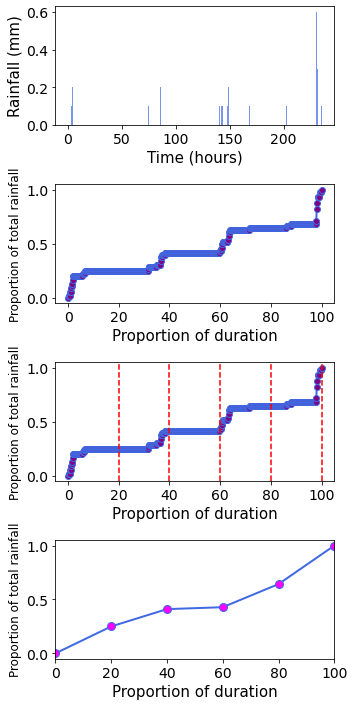

In [90]:
fig, axs = plt.subplots(4, 1, figsize=(5, 12))  
plt.subplots_adjust(hspace=0.5)

# Plot each element in its own axis.
plot_raw_data(event_rainfall, axs[0])
plot_dimensionless_cumulative(event_rainfall, dimensionless_cumulative_event, axs[1], False)
plot_dimensionless_cumulative(event_rainfall, dimensionless_cumulative_event, axs[2], boundaries_boolean =True)
plot_interpolated_cumulative(itpld_dimensionless_cumulative_event, axs[3])
# plot_incremental_rainfall(interpolated_n_incremental_rainfall, axs[4], labels=labels)

# Adjust tick parameters for all subplots.
for ax in axs:
    ax.tick_params(axis='both', labelsize=14)

In [48]:
# Analysis
analysis = rainfall_analysis(ts)
analysis.get_metrics()

In [45]:
# test =pd.DataFrame({'O1': analysis.metrics['huff_quantile'].flatten(), 
#                     'O2':analysis.metrics['huff_quantile_molly'].flatten()})